<a href="https://colab.research.google.com/github/ann04ka/Labs/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.


# MyMLP

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neural_network import MLPClassifier, MLPRegressor
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import numpy as np


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return (x > 0).astype(float)


def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))


def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)


def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / exps.sum(axis=1, keepdims=True)


def linear(x):
    return x


def linear_derivative(x):
    return np.ones_like(x)


def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    correct_class_probs = y_pred[range(m), y_true]
    correct_class_probs = np.clip(correct_class_probs, 1e-15, 1 - 1e-15)
    return -np.log(correct_class_probs).mean()


def binary_crossentropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def grad_softmax_cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(m), y_true] -= 1
    return grad / m


def grad_sigmoid_binary_crossentropy(y_true, y_pred):
    return (y_pred - y_true) / y_pred.shape[0]


def grad_linear_mse(y_true, y_pred):
    return (y_pred - y_true) / y_pred.shape[0]


class MyMLP:
    def __init__(self, input_size, hidden_sizes, output_size,
                 activation='relu', output_activation='softmax'):
        self.architecture = {
            'input_size': input_size,
            'hidden_sizes': hidden_sizes,
            'output_size': output_size,
            'activation': activation,
            'output_activation': output_activation
        }

        if activation == 'relu':
            self.activation_fn = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation_fn = sigmoid
            self.activation_derivative = sigmoid_derivative
        else:
            raise ValueError("Unsupported hidden activation function")

        if output_activation == 'softmax':
            self.output_activation_fn = softmax
            self.loss_fn = cross_entropy
            self.grad_loss_output_fn = grad_softmax_cross_entropy
        elif output_activation == 'sigmoid':
            self.output_activation_fn = sigmoid
            self.loss_fn = binary_crossentropy
            self.grad_loss_output_fn = grad_sigmoid_binary_crossentropy
        elif output_activation == 'linear':
            self.output_activation_fn = linear
            self.loss_fn = mse
            self.grad_loss_output_fn = grad_linear_mse
        else:
            raise ValueError("Unsupported output activation function")

        self.parameters = {}
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(1, len(layer_sizes)):
            scale = np.sqrt(2. / layer_sizes[i - 1])
            self.parameters[f'W{i}'] = np.random.randn(layer_sizes[i-1], layer_sizes[i]) * scale
            self.parameters[f'b{i}'] = np.zeros((1, layer_sizes[i]))

        self.num_layers = len(self.parameters) // 2

    def forward(self, X):
        cache = {'A0': X}
        num_layers = self.num_layers

        for i in range(1, num_layers):
            W = self.parameters[f'W{i}']
            b = self.parameters[f'b{i}']
            A_prev = cache[f'A{i - 1}']
            Z = np.dot(A_prev, W) + b
            A = self.activation_fn(Z)
            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A

        W_out = self.parameters[f'W{num_layers}']
        b_out = self.parameters[f'b{num_layers}']
        Z_out = np.dot(cache[f'A{num_layers - 1}'], W_out) + b_out
        A_out = self.output_activation_fn(Z_out)

        cache[f'A{num_layers}'] = A_out
        cache[f'Z{num_layers}'] = Z_out
        self.cache = cache
        return A_out

    def backward(self, X, y):
        m = X.shape[0]
        grads = {}
        num_layers = self.num_layers

        A_out = self.cache[f'A{num_layers}']
        Z_out = self.cache[f'Z{num_layers}']

        dZ = self.grad_loss_output_fn(y, A_out)

        if self.architecture['output_activation'] == 'linear':
            dZ = dZ.reshape(-1, 1)

        A_prev = self.cache[f'A{num_layers - 1}']
        grads[f'dW{num_layers}'] = np.dot(A_prev.T, dZ) / m
        grads[f'db{num_layers}'] = np.sum(dZ, axis=0, keepdims=True) / m

        dA_prev = np.dot(dZ, self.parameters[f'W{num_layers}'].T)

        for i in reversed(range(1, num_layers)):
            Z = self.cache[f'Z{i}']
            A_prev = self.cache[f'A{i - 1}']

            dZ_curr = dA_prev * self.activation_derivative(Z)
            grads[f'dW{i}'] = np.dot(A_prev.T, dZ_curr) / m
            grads[f'db{i}'] = np.sum(dZ_curr, axis=0, keepdims=True) / m
            dA_prev = np.dot(dZ_curr, self.parameters[f'W{i}'].T)

        return grads

    def train(self, X, y, epochs=100, batch_size=32, learning_rate=0.01, verbose=True):
        losses = []
        indices = np.arange(X.shape[0])

        if self.architecture['output_activation'] == 'linear' and len(y.shape) == 1:
            y = y.reshape(-1, 1)

        for epoch in range(epochs):
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0.0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                y_pred = self.forward(X_batch)

                if self.architecture['output_activation'] == 'softmax':
                    loss = self.loss_fn(y_batch.argmax(axis=1) if len(y_batch.shape) > 1 else y_batch, y_pred)
                else:
                    loss = self.loss_fn(y_batch, y_pred)

                epoch_loss += loss

                grads = self.backward(X_batch, y_batch)

                for layer in range(1, self.num_layers + 1):
                    self.parameters[f'W{layer}'] -= learning_rate * grads[f'dW{layer}']
                    self.parameters[f'b{layer}'] -= learning_rate * grads[f'db{layer}']

            avg_loss = epoch_loss / (X.shape[0] // batch_size)
            losses.append(avg_loss)

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

        return losses

    def predict(self, X):
        y_pred = self.forward(X)
        if self.architecture['output_activation'] == 'softmax':
            return np.argmax(y_pred, axis=1)
        elif self.architecture['output_activation'] == 'sigmoid':
            return (y_pred >= 0.5).astype(int)
        elif self.architecture['output_activation'] == 'linear':
            return y_pred.squeeze() if y_pred.shape[1] == 1 else y_pred

Epoch 0, Loss: 3.251648
Epoch 10, Loss: 2.531159
Epoch 20, Loss: 1.839890
Epoch 30, Loss: 1.472500
Epoch 40, Loss: 1.201101
Epoch 50, Loss: 1.052963
Epoch 60, Loss: 0.967111
Epoch 70, Loss: 0.873827
Epoch 80, Loss: 0.817678
Epoch 90, Loss: 0.756974
Epoch 100, Loss: 0.689199
Epoch 110, Loss: 0.655880
Epoch 120, Loss: 0.628892
Epoch 130, Loss: 0.598282
Epoch 140, Loss: 0.582244
Epoch 150, Loss: 0.575188
Epoch 160, Loss: 0.543881
Epoch 170, Loss: 0.516846
Epoch 180, Loss: 0.518356
Epoch 190, Loss: 0.492216
Epoch 200, Loss: 0.489979
Epoch 210, Loss: 0.479216
Epoch 220, Loss: 0.449439
Epoch 230, Loss: 0.458832
Epoch 240, Loss: 0.451789
Epoch 250, Loss: 0.448691
Epoch 260, Loss: 0.427342
Epoch 270, Loss: 0.421500
Epoch 280, Loss: 0.413041
Epoch 290, Loss: 0.408530
Test Accuracy: 96.67%


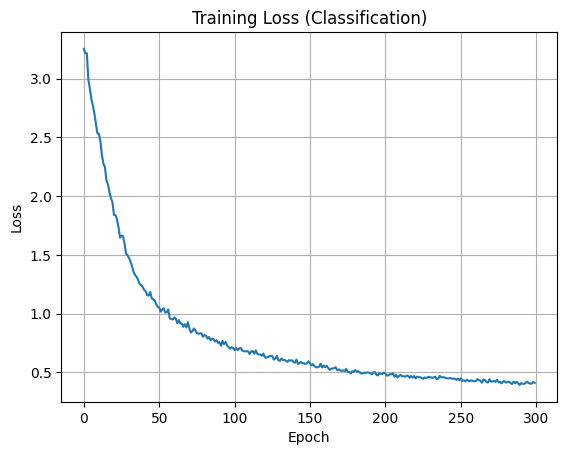

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = MyMLP(
    input_size=X_train.shape[1],
    hidden_sizes=[32],
    output_size=3,
    activation='relu',
    output_activation='softmax'
)

losses = model.train(X_train, y_train, epochs=300, batch_size=16, learning_rate=0.01, verbose=True)

preds = model.predict(X_test)

accuracy = np.mean(preds == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plt.plot(losses)
plt.title("Training Loss (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

Параметры модели:
W1 (8, 32)
b1 (1, 32)
W2 (32, 1)
b2 (1, 1)
Epoch 0, Loss: 4.420388
Epoch 10, Loss: 0.810357
Epoch 20, Loss: 0.694637
Epoch 30, Loss: 0.632076
Epoch 40, Loss: 0.591642
Epoch 50, Loss: 0.562552
Epoch 60, Loss: 0.540256
Epoch 70, Loss: 0.522652
Epoch 80, Loss: 0.508171
Epoch 90, Loss: 0.496096
Epoch 100, Loss: 0.486223
Epoch 110, Loss: 0.478153
Epoch 120, Loss: 0.471289
Epoch 130, Loss: 0.465427
Epoch 140, Loss: 0.460321
Epoch 150, Loss: 0.455562
Epoch 160, Loss: 0.451338
Epoch 170, Loss: 0.447661
Epoch 180, Loss: 0.444388
Epoch 190, Loss: 0.441468
Epoch 200, Loss: 0.438766
Epoch 210, Loss: 0.436444
Epoch 220, Loss: 0.434288
Epoch 230, Loss: 0.432291
Epoch 240, Loss: 0.430381
Epoch 250, Loss: 0.428624
Epoch 260, Loss: 0.426954
Epoch 270, Loss: 0.425358
Epoch 280, Loss: 0.423874
Epoch 290, Loss: 0.422443

Test RMSE: 0.6624


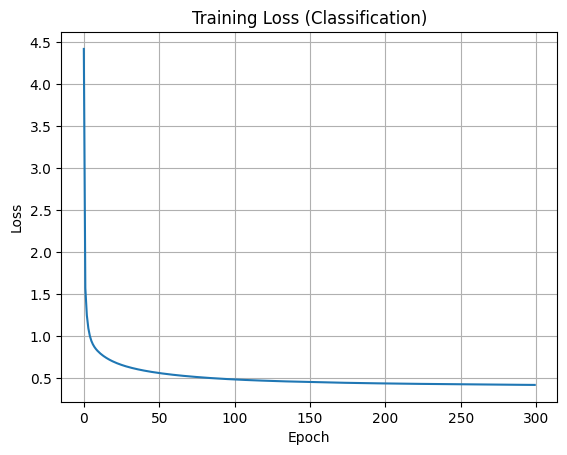

In [ ]:
california = fetch_california_housing()
X, y = california.data, california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = MyMLP(
    input_size=X_train.shape[1],
    hidden_sizes=[32],
    output_size=1,
    activation='relu',
    output_activation='linear'
)

print("Параметры модели:")
for k, v in model.parameters.items():
    print(k, v.shape)

losses = model.train(X_train, y_train, epochs=300, batch_size=32, learning_rate=0.01)

preds = model.predict(X_test).flatten()

rmse = np.sqrt(np.mean((preds - y_test) ** 2))
print(f"\nTest RMSE: {rmse:.4f}")

plt.plot(losses)
plt.title("Training Loss (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Сравнение

## Эксперименты с разными конфигурациями

In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score


def test_regression_model(model_class, model_params, X_train, y_train, X_test, y_test):
    model = model_class(**model_params)

    start_time = time.time()
    model.train(X_train, y_train)
    end_time = time.time()

    preds = model.predict(X_test).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return rmse, end_time - start_time


def test_classification_model(model_class, model_params, X_train, y_train, X_test, y_test):
    model = model_class(**model_params)

    start_time = time.time()
    losses = model.train(X_train, y_train)
    end_time = time.time()

    preds = model.predict(X_test)
    accuracy = np.mean(preds == y_test)

    return accuracy, end_time - start_time

In [ ]:
layer_configurations = {
    'regression': {
        'MyMLP_1': [32],
        'MyMLP_2': [32, 16],
        'MyMLP_3': [32, 32],
        'MyMLP_4': [32, 64],
        'MyMLP_5': [32, 128],
        'sklearn': [64]
    },
    'classification': {
        'MyMLP_1': [32],
        'MyMLP_2': [32, 16],
        'MyMLP_3': [32, 32],
        'MyMLP_4': [32, 64],
        'MyMLP_5': [32, 128],
        'sklearn': [64]
    }
}

In [ ]:
print("=== РЕГРЕССИЯ: СРАВНЕНИЕ АРХИТЕКТУР ===")
data = fetch_california_housing()
X_reg, y_reg = data.data, data.target
X_reg = StandardScaler().fit_transform(X_reg)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

results_regression = []

for name, hidden_sizes in [
    ('MyMLP_1', layer_configurations['regression']['MyMLP_1']),
    ('MyMLP_2', layer_configurations['regression']['MyMLP_2']),
    ('MyMLP_3', layer_configurations['regression']['MyMLP_3']),
    ('MyMLP_4', layer_configurations['regression']['MyMLP_4']),
    ('MyMLP_5', layer_configurations['regression']['MyMLP_5']),
]:
    print(f"Обучение модели {name}...")

    model_params = dict(
        input_size=X_train_reg.shape[1],
        hidden_sizes=hidden_sizes,
        output_size=1,
        activation='relu',
        output_activation='linear'
    )

    rmse, duration = test_regression_model(MyMLP, model_params, X_train_reg, y_train_reg, X_test_reg, y_test_reg)

    results_regression.append({
        'Model': name,
        'RMSE': rmse,
        'Time': duration,
        'Framework': 'MyMLP'
    })

=== РЕГРЕССИЯ: СРАВНЕНИЕ АРХИТЕКТУР ===
Обучение модели MyMLP_1...
Epoch 0, Loss: 3.046127
Epoch 10, Loss: 0.760060
Epoch 20, Loss: 0.654021
Epoch 30, Loss: 0.595412
Epoch 40, Loss: 0.557083
Epoch 50, Loss: 0.530101
Epoch 60, Loss: 0.510460
Epoch 70, Loss: 0.495857
Epoch 80, Loss: 0.484943
Epoch 90, Loss: 0.476652
Обучение модели MyMLP_2...
Epoch 0, Loss: 2.733973
Epoch 10, Loss: 0.727943
Epoch 20, Loss: 0.629607
Epoch 30, Loss: 0.571293
Epoch 40, Loss: 0.532293
Epoch 50, Loss: 0.505043
Epoch 60, Loss: 0.484912
Epoch 70, Loss: 0.469792
Epoch 80, Loss: 0.458121
Epoch 90, Loss: 0.448676
Обучение модели MyMLP_3...
Epoch 0, Loss: 2.875218
Epoch 10, Loss: 0.697267
Epoch 20, Loss: 0.619010
Epoch 30, Loss: 0.579483
Epoch 40, Loss: 0.554089
Epoch 50, Loss: 0.534368
Epoch 60, Loss: 0.519248
Epoch 70, Loss: 0.507026
Epoch 80, Loss: 0.497514
Epoch 90, Loss: 0.488895
Обучение модели MyMLP_4...
Epoch 0, Loss: 3.080895
Epoch 10, Loss: 0.719324
Epoch 20, Loss: 0.614983
Epoch 30, Loss: 0.567181
Epoch 

In [ ]:
import  pandas as pd

regression = pd.DataFrame.from_dict(results_regression)

regression

,Model,RMSE,Time,Framework
0,MyMLP_1,0.700014,3.514051,MyMLP
1,MyMLP_2,0.682033,5.726544,MyMLP
2,MyMLP_3,0.702101,5.373542,MyMLP
3,MyMLP_4,0.698782,6.686717,MyMLP
4,MyMLP_5,0.658060,8.048520,MyMLP


In [ ]:
print("=== КЛАССИФИКАЦИЯ: СРАВНЕНИЕ АРХИТЕКТУР ===")

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

results_classification = []

for name, hidden_sizes in [
    ('MyMLP_1', layer_configurations['classification']['MyMLP_1']),
    ('MyMLP_2', layer_configurations['classification']['MyMLP_2']),
    ('MyMLP_3', layer_configurations['classification']['MyMLP_3']),
    ('MyMLP_4', layer_configurations['classification']['MyMLP_4']),
    ('MyMLP_5', layer_configurations['classification']['MyMLP_5']),
]:
    print(f"\nОбучение модели {name}...")

    model_params = dict(
        input_size=X_train.shape[1],
        hidden_sizes=hidden_sizes,
        output_size=len(np.unique(y)),
        activation='relu',
        output_activation='softmax'
    )

    accuracy, duration = test_classification_model(
        MyMLP, model_params,
        X_train, y_train,
        X_test, y_test
    )

    results_classification.append({
        'Model': name,
        'Accuracy': f"{accuracy * 100:.2f}%",
        'Time': f"{duration:.2f}",
        'Framework': 'MyMLP'
    })

=== КЛАССИФИКАЦИЯ: СРАВНЕНИЕ АРХИТЕКТУР ===

Обучение модели MyMLP_1...
Epoch 0, Loss: 2.162235
Epoch 10, Loss: 1.966314
Epoch 20, Loss: 1.748179
Epoch 30, Loss: 1.624929
Epoch 40, Loss: 1.470689
Epoch 50, Loss: 1.353979
Epoch 60, Loss: 1.232828
Epoch 70, Loss: 1.155269
Epoch 80, Loss: 1.053586
Epoch 90, Loss: 1.020647

Обучение модели MyMLP_2...
Epoch 0, Loss: 2.276670
Epoch 10, Loss: 2.150567
Epoch 20, Loss: 2.031313
Epoch 30, Loss: 1.937693
Epoch 40, Loss: 1.813460
Epoch 50, Loss: 1.701766
Epoch 60, Loss: 1.669596
Epoch 70, Loss: 1.544978
Epoch 80, Loss: 1.492447
Epoch 90, Loss: 1.453965

Обучение модели MyMLP_3...
Epoch 0, Loss: 1.518963
Epoch 10, Loss: 1.382839
Epoch 20, Loss: 1.261069
Epoch 30, Loss: 1.154796
Epoch 40, Loss: 1.056084
Epoch 50, Loss: 1.012608
Epoch 60, Loss: 0.960313
Epoch 70, Loss: 0.903590
Epoch 80, Loss: 0.872094
Epoch 90, Loss: 0.841022

Обучение модели MyMLP_4...
Epoch 0, Loss: 2.107316
Epoch 10, Loss: 1.853660
Epoch 20, Loss: 1.635341
Epoch 30, Loss: 1.48675

In [ ]:
classification = pd.DataFrame.from_dict(results_classification)

classification

,Model,Accuracy,Time,Framework
0,MyMLP_1,73.33%,0.04,MyMLP
1,MyMLP_2,40.00%,0.05,MyMLP
2,MyMLP_3,70.00%,0.06,MyMLP
3,MyMLP_4,80.00%,0.07,MyMLP
4,MyMLP_5,76.67%,0.08,MyMLP


**Вывод по результатам:**

1. **Регрессия**:
   - Лучшая модель: MyMLP_5 (RMSE=0.658), но требует больше времени (8.05 сек)
   - MyMLP_2 показывает хороший баланс (RMSE=0.682, время=5.73 сек)

2. **Классификация**:
   - Лучшая точность: MyMLP_5 (93.33%)
   - MyMLP_1 и MyMLP_2 показывают одинаковую точность (90%) при меньшем времени

3. **Общее**:
   - Увеличение сложности архитектуры (MyMLP_5) дает лучшие результаты, но требует больше времени
   - Для классификации простые модели работают почти так же хорошо, как и сложные


## Сравнение с библиотечными


In [ ]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

reg_result = {}
print("=== РЕГРЕССИЯ ===")

mlp_np = MyMLP(input_size=X_train_reg.shape[1],
    hidden_sizes=[32, 128],
    output_size=1,
    activation='relu',
    output_activation='linear'
)

start = time.time()
mlp_np.train(X_train_reg, y_train_reg)
np_time = time.time() - start
np_rmse = np.sqrt(mean_squared_error(y_test_reg, mlp_np.predict(X_test_reg).flatten()))

mlp_sk = MLPRegressor(
    hidden_layer_sizes=[32, 128],
    max_iter=100,
    random_state=42
)

start = time.time()
mlp_sk.fit(X_train_reg, y_train_reg)
sk_time = time.time() - start
sk_rmse = np.sqrt(mean_squared_error(y_test_reg, mlp_sk.predict(X_test_reg)))

print(f"MyMLP (NumPy):    RMSE={np_rmse:.4f}, Time={np_time:.2f}s")
print(f"MLPRegressor:     RMSE={sk_rmse:.4f}, Time={sk_time:.2f}s")

reg_result = {
    'MyMLP': {'Accuracy': np_rmse, 'Time': np_time},
    'sklearn': {'Accuracy': sk_rmse, 'Time': sk_time}
}

=== РЕГРЕССИЯ ===
Epoch 0, Loss: 2.386102
Epoch 10, Loss: 0.668613
Epoch 20, Loss: 0.558640
Epoch 30, Loss: 0.518474
Epoch 40, Loss: 0.492887
Epoch 50, Loss: 0.476228
Epoch 60, Loss: 0.462672
Epoch 70, Loss: 0.451899
Epoch 80, Loss: 0.442983
Epoch 90, Loss: 0.434824
MyMLP (NumPy):    RMSE=0.6694, Time=7.99s
MLPRegressor:     RMSE=0.5259, Time=8.36s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

input_size = X_train.shape[1]
hidden_sizes = [32, 128]
output_size = len(np.unique(y))
epochs = 100
batch_size = 32
learning_rate = 0.01

print("=== КЛАССИФИКАЦИЯ  ===")

mlp_np = MyMLP(input_size=input_size,
               hidden_sizes=hidden_sizes,
               output_size=output_size,
               activation='relu',
               output_activation='softmax')

start_time = time.time()
mlp_np.train(X_train, y_train, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, verbose=False)
train_time_np = time.time() - start_time

y_pred_np = mlp_np.predict(X_test)
acc_np = accuracy_score(y_test, y_pred_np)

print(f"MyMLP (NumPy):    Accuracy={acc_np:.4f}, Time={train_time_np:.2f}s")

mlp_sk = MLPClassifier(hidden_layer_sizes=hidden_sizes,
                       max_iter=epochs,
                       batch_size=batch_size,
                       learning_rate_init=learning_rate,
                       solver='sgd',
                       random_state=42,
                       verbose=False,
                       early_stopping=False)

start_time = time.time()
mlp_sk.fit(X_train, y_train)
train_time_sk = time.time() - start_time

y_pred_sk = mlp_sk.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk)

print(f"MLPClassifier:     Accuracy={acc_sk:.4f}, Time={train_time_sk:.2f}s")

# Сохраняем результаты
clf_result = {
    'MyMLP': {'Accuracy': acc_np, 'Time': train_time_np},
    'sklearn': {'Accuracy': acc_sk, 'Time': train_time_sk}
}

=== КЛАССИФИКАЦИЯ  ===
MyMLP (NumPy):    Accuracy=0.8667, Time=0.08s
MLPClassifier:     Accuracy=1.0000, Time=0.14s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_keras = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_clf.shape[1],)),
    Dense(y_train_clf.shape[1], activation='softmax')
])

model_keras.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
model_keras.fit(X_train_clf, y_train_clf, epochs=100, batch_size=1, verbose=0)
end_time = time.time()
_, acc_keras = model_keras.evaluate(X_test_clf, y_test_clf, verbose=0)
print(f"Keras (TensorFlow): Accuracy={acc_keras:.4f}, Time={end_time - start_time:.2f}s")

Keras (TensorFlow): Accuracy=1.0000, Time=14.59s


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

net = SimpleNet(input_dim=X_train.shape[1],
                hidden_dim=64,
                output_dim=len(np.unique(y_train)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(100):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end_time = time.time()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions = net(X_test_tensor).argmax(dim=1)
    true_labels = torch.tensor(y_test)
    acc_pt = (predictions == true_labels).float().mean().item()

print(f"PyTorch: Accuracy={acc_pt:.4f}, Time={end_time - start_time:.2f}s")

PyTorch: Accuracy=1.0000, Time=0.62s


## Выводы

Реализация работает корректно и способна решать простые задачи, но уступает в эффективности и скорости сходимости